# Test of CAMB_GammaPrime_Growth
CAMB_GammaPrime_Growth is a modified version of CAMB, where the nonlinear module halofit is modified to allow for a gamma parametrization of growth rate.
- The considered gamma parametrization assumes the form $$f(z)=\Omega_m(z)^{\gamma(z)},$$ where $\gamma(z)=\gamma_0+\gamma_1*z$.
- All changes are limited to within the CAMB nonlinear halofit module. Within which, we rescale the linear matter power spectrum $P_{\mathrm{lin}}(k,z)$ that enters the estimation of the two-halo term $P_{\mathrm{2-halo}}(k,z,P_{\mathrm{lin}})$.
Reference: Eq. 14-16 in [Mead2020][1]

[1]: https://arxiv.org/abs/2009.01858

## Load some basic libraries and check CAMB installation path

In [3]:
import sys, platform, os
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('Minh_paper_style')
import matplotlib.pyplot as plt
from matplotlib.ticker import (FixedLocator, MultipleLocator, FixedFormatter, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib import cm
from matplotlib.colors import ListedColormap

#Assume installed from github using "git clone --recursive https://github.com/cmbant/CAMB.git"
#This file is then in the docs folders
#camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
#sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.6 installed at /nfs/turbo/lsa-nguyenmn/cosmo_analysis/cobaya_intel/code/CAMB-Growth/camb


# Generate $P(k)$ from default, unmodified CAMB. Note: make sure the CAMB path printed above is for unmodfied version of CAMB

In [2]:
cosmo_params = camb.CAMBparams()
### Consider LCDM cosmology with only one massive neutrino, helium then set through the BBN consistency
#cosmo_params.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06,gamma0=0.55,gamma1=0.0)
cosmo_params.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
#### Consider the usual power-law initial power spectrum (of primordial fluctuations)
cosmo_params.InitPower.set_params(As=2e-9, ns=0.965, r=0)

redshift_snaphots=[1.5,0.]
kmin=1e-4
kmax=2.0

### Note that here you probably want to extend the k-range to at least 2 kmax being considered later
cosmo_params.set_matter_power(redshifts=redshift_snaphots, kmax=2*kmax);

### Linear power spectra
#cosmo_params.set_dark_energy(w=-0.8, wa=0.2, dark_energy_model='fluid') 
cosmo_params.NonLinear = model.NonLinear_none
results = camb.get_results(cosmo_params)
kh, z, pk_lin = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints = 200)
print(pk_lin.shape)
#np.savetxt('testpklin_CAMB-mod_gamma0p55_z1p5.txt',np.c_[kh,pk_lin[1,:]])
np.savetxt('test_pklin_CAMB-original_z1p5.txt',np.c_[kh,pk_lin[1,:]])


### Non-linear power spectra (Halofit)
cosmo_params.NonLinear = model.NonLinear_both
cosmo_params.NonLinearModel.set_params(halofit_version='mead2020')
results.calc_power_spectra(cosmo_params)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints = 200)
#np.savetxt('test_pknonlin_CAMB-mod_gamma0p55_z1p5.txt',np.c_[kh,pk_nonlin[1,:]])
np.savetxt('test_pknonlin_CAMB-original_z1p5.txt',np.c_[kh,pk_nonlin[1,:]])


(2, 200)


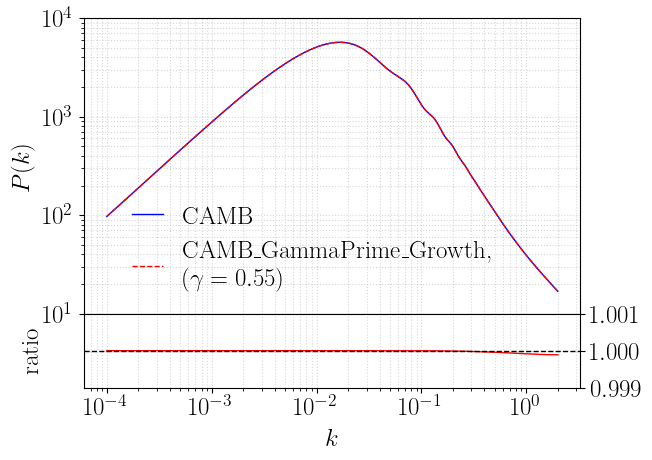

In [3]:
pk_original_file='./test_pknonlin_CAMB-original_z1p5.txt'
pk_gamma_file='./test_pknonlin_CAMB-mod_gamma0p55_z1p5.txt'
k=np.loadtxt(pk_original_file,usecols=0)
pk_original=np.loadtxt(pk_original_file,usecols=1)
pk_gamma=np.loadtxt(pk_gamma_file,usecols=1)

fig, ax = plt.subplots(2, sharex=True, sharey=False, gridspec_kw={'hspace': 0., 'wspace':0., 'height_ratios':[8, 2]}, figsize=(6.4, 4.8))
ax[0].loglog(k,pk_original,ls='-',c='b',label=r'CAMB')
ax[0].loglog(k,pk_gamma,ls='--',c='r',label="CAMB_GammaPrime_Growth,\n$(\gamma=0.55)$")
ax[0].axhline(y=1.0,ls='--',c='k')
ax[0].grid(True, which="both", ls=":",alpha=0.5)
ax[0].set_ylim(10,1E4)
ax[1].set_xlabel(r'$k$')
ax[0].set_ylabel(r'$P(k)$')
ax[1].semilogx(k,pk_gamma/pk_original,color='r')
ax[1].set_ylim(1-1E-3,1+1E-3)
ax[1].yaxis.tick_right()
ax[1].axhline(y=1.0,ls='--',c='k')
ax[1].grid(True,which="both",ls=':',alpha=0.5)
ax[1].set_ylabel(r'ratio',labelpad=30)
ax[0].legend(loc='lower left',bbox_to_anchor=((0.05,0,1,1)),handlelength=1.25);
#ax[0].set_title('LCDM vs. $\gamma_0=0.55,\gamma_1=1.0$ growth factor');
fig.savefig('CAMB_comparison.pdf')

## Set up two cosmologies, with $\gamma=0.55$ (GR-LCDM) and $\gamma=1.0$

## Call CAMB to solve the coupled Bolztmann equations for the given cosmologies, assuming the same primordial power spectrum

## $\gamma=0.55$

In [43]:
cosmo_params = camb.CAMBparams()
### Consider LCDM cosmology with only one massive neutrino, helium then set through the BBN consistency
cosmo_params.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06,gamma0=0.55,gamma1=0.0)
#cosmo_params.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
#### Consider the usual power-law initial power spectrum (of primordial fluctuations)
cosmo_params.InitPower.set_params(As=2e-9, ns=0.965, r=0)

redshift_snaphots=[1.5,0.]
kmin=1e-4
kmax=2.0

### Note that here you probably want to extend the k-range to at least 2 kmax being considered later
cosmo_params.set_matter_power(redshifts=redshift_snaphots, kmax=2*kmax);

### Linear power spectra
#cosmo_params.set_dark_energy(w=-0.8, wa=0.2, dark_energy_model='fluid') 
cosmo_params.NonLinear = model.NonLinear_none
results = camb.get_results(cosmo_params)
kh, z, pk_lin = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints = 200)
print(pk_lin.shape)
#np.savetxt('testpklin_CAMB-mod_gamma0p55_z1p5.txt',np.c_[kh,pk_lin[1,:]])
#np.savetxt('test_pklin_CAMB-original_z1p5.txt',np.c_[kh,pk_lin[1,:]])


### Non-linear power spectra (Halofit)
cosmo_params.NonLinear = model.NonLinear_both
cosmo_params.NonLinearModel.set_params(halofit_version='mead2020')
results.calc_power_spectra(cosmo_params)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints = 200)
#np.savetxt('test_pknonlin_CAMB-mod_gamma0p55_z1p5.txt',np.c_[kh,pk_nonlin[1,:]])
#np.savetxt('test_pknonlin_CAMB-original_z1p5.txt',np.c_[kh,pk_nonlin[1,:]])


(2, 200)


## $\gamma=1.0$

In [44]:
cosmo_params = camb.CAMBparams()
### Consider LCDM cosmology with only one massive neutrino, helium then set through the BBN consistency
cosmo_params.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06,gamma0=1.0,gamma1=0.0)
#### Consider the usual power-law initial power spectrum (of primordial fluctuations)
cosmo_params.InitPower.set_params(As=2e-9, ns=0.965, r=0)

redshift_snaphots=[1.5,0.]
kmin=1e-4
kmax=2.0

### Note that here you probably want to extend the k-range to at least 2 kmax being considered later
cosmo_params.set_matter_power(redshifts=redshift_snaphots, kmax=2*kmax);

### Linear power spectra
#cosmo_params.set_dark_energy(w=-0.8, wa=0.2, dark_energy_model='fluid') 
cosmo_params.NonLinear = model.NonLinear_none
results = camb.get_results(cosmo_params)
kh, z, pk_lin_gamma = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints = 200)
#np.savetxt('test_pklin_gamma0_1_z1p5.txt',np.c_[kh,pk_lin_gamma[1,:]])

### Non-linear power spectra (Halofit)
cosmo_params.NonLinear = model.NonLinear_both
cosmo_params.NonLinearModel.set_params(halofit_version='mead2020')
results.calc_power_spectra(cosmo_params)
kh_nonlin, z_nonlin, pk_nonlin_gamma = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints = 200)
#np.savetxt('test_pknonlin_gamma0_1_z1p5.txt',np.c_[kh,pk_nonlin_gamma[1,:]])
print("Sigma8 at the corresponding redshifts:")
results.get_sigma8()

Sigma8 at the corresponding redshifts:


array([0.39790578, 0.8025233 ])

## Compare linear and nonlinear matter power spectra at z=0.,1.5

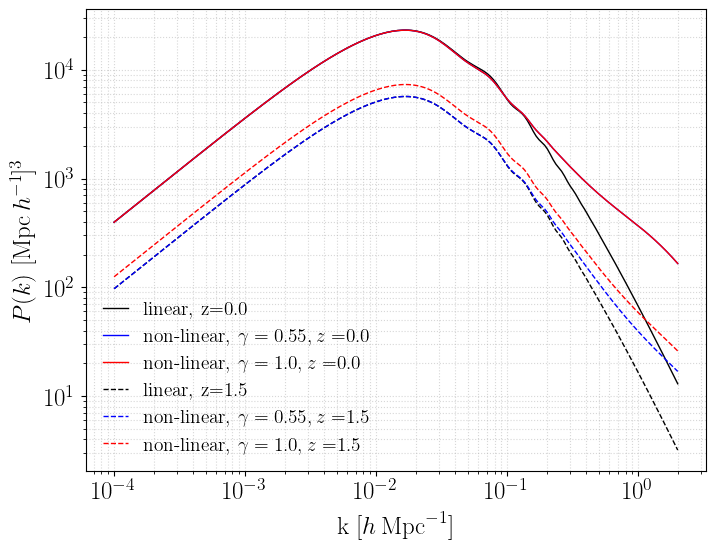

In [45]:
fig,ax=plt.subplots()
for i, (redshift, line) in enumerate(zip(z,['-','--'])):
    ax.loglog(kh, pk_lin[i,:], color='k', ls = line, label='linear, z=%s'%z[i])
    ax.loglog(kh_nonlin, pk_nonlin[i,:], color='b', ls = line, label='non-linear, $\gamma=0.55, z=$%s'%z[i])
    ax.loglog(kh_nonlin, pk_nonlin_gamma[i,:], color='r', ls = line, label='non-linear, $\gamma=1.0, z=$%s'%z[i])
ax.set_xlabel(r'k $[h\,\mathrm{Mpc}^{-1}]$')
ax.set_ylabel(r'$P(k)$ $[\mathrm{Mpc}\,h^{-1}]^3$')
#ax.set_ylim(1,3E4)
ax.grid(True, which="both", ls=":",alpha=0.5)
ax.legend(loc='lower left',fontsize=14,handlelength=1.25);

# Below are some further checks of the numerical integration of $D(z)$ in CAMB_GammaPrimeGrowth

## Plot $D(a)$ in CAMB_GammaPrime_Growth for a few values of $\gamma$

In [20]:
cosmo_params = camb.CAMBparams()
cosmo_params.InitPower.set_params(As=2e-9, ns=0.965, r=0)
kmin=1e-4
kmax=2.0
npoints=int(50)
a=np.linspace(0.1,1.0,npoints)
z=-1+1./a
cosmo_params.set_matter_power(redshifts=z, kmax=2*kmax)

gammas=np.arange(0.3,0.85,0.05)
D=[]

for gamma in gammas:
    ### Consider LCDM cosmology with only one massive neutrino, helium then set through the BBN consistency
    cosmo_params.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06,gamma0=gamma,gamma1=0.0)
    #cosmo_params.NonLinear = model.NonLinear_none
    #results = camb.get_results(cosmo_params)
    #kh, z, pk_lin = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints = 200)
    cosmo_params.NonLinear = model.NonLinear_both
    results = camb.get_results(cosmo_params)
    kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints = 200)
    D.append(np.sqrt(pk_nonlin[:,4]/pk_nonlin[0,4]))
    
D=np.asarray(D)

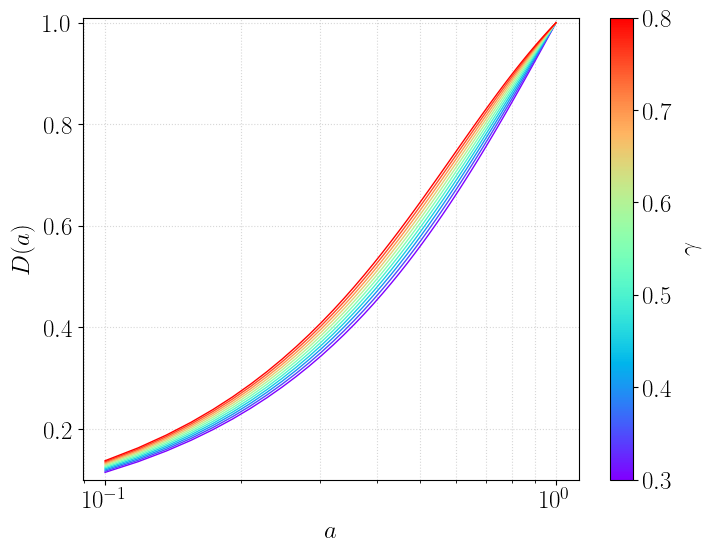

In [28]:
colors = iter(cm.rainbow(np.linspace(0, 1, len(gammas))))
fig,ax=plt.subplots()
for g,gamma in enumerate(gammas):
    c = next(colors)
    ax.semilogx(a,D[g,::-1],ls='-',c=c)

ax.set_xlabel(r'$a$',fontsize=18)
ax.set_ylabel(r'$D(a)$',fontsize=18)
ax.set_ylim(0.1,1.01)
ax.grid(True, which="both", ls=":",alpha=0.5)
norm=matplotlib.colors.Normalize(vmin=gammas[0],vmax=gammas[-1])
cbar=fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cm.rainbow))
cbar.set_label(r'$\gamma$')
#ax.legend(loc='lower left')
#ax.set_title(r'LCDM growth rate in $\gamma$ approximation');

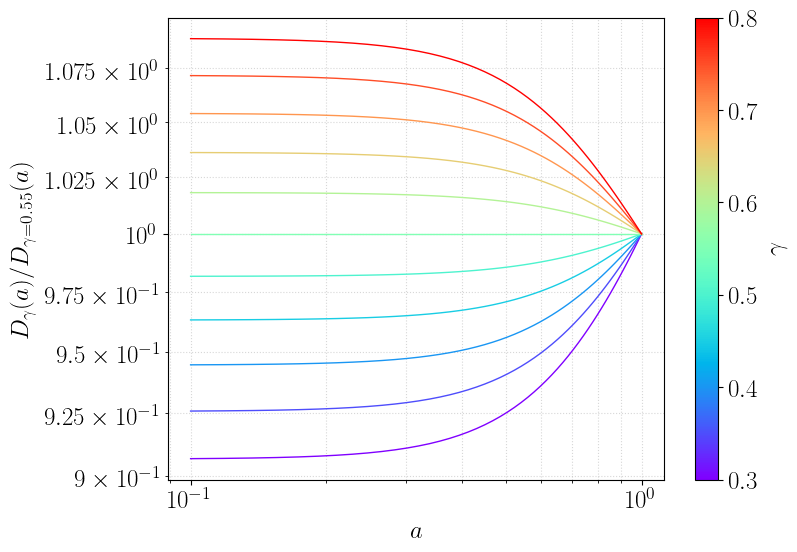

In [15]:
colors = iter(cm.rainbow(np.linspace(0, 1, len(gammas))))
fig,ax=plt.subplots()
for g,gamma in enumerate(gammas):
    c = next(colors)
    ax.loglog(a,D[g,::-1]/D[5,::-1],ls='-',c=c)

ax.set_xlabel(r'$a$',fontsize=18)
ax.set_ylabel(r'$D_{\gamma}(a)/D_{\gamma=0.55}(a)$',fontsize=18)
ax.grid(True, which="both", ls=":",alpha=0.5)
norm=matplotlib.colors.Normalize(vmin=gammas[0],vmax=gammas[-1])
cbar=fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cm.rainbow))
cbar.set_label(r'$\gamma$')
#ax.legend(loc='lower left')
#ax.set_title(r'LCDM growth rate in $\gamma$ approximation');

## Numpy version of the integral of $D(z)$, can be used to cross-check the $D(z)$ integral and the $P(k)$ rescaling in CAMB_GammaPrime_Growth

In [ ]:
import scipy.integrate as integrate

def growth_rate(a,Omega_m,gamma0=0.55,gamma1=0.0):
    z=-1+1./a
    gamma=gamma0+gamma1*z
    growth_rate=np.power(Omega_m,gamma)
    return growth_rate

# def growth_factor(a,growth_rate,dx=1E-4):
#     integrand=[]
#     for i,a_i in enumerate(a):
#         integrand.append(integrate.simpson(-growth_rate[i:]/a[i:],a[i:]))
#     integrand=np.asarray(integrand)
#     growth_factor=np.exp(integrand)
#     return growth_factor
### The function above computes the numerical integral D(z) and accumulates the D(z) array correctly but not very clever
### it re-computes the same integral interval multiple times
### below we will try a different approach that only computes the next segment of the integral each time
def growth_factor(a,growth_rate,dx=1E-4):
    integrand=[]
    start_sum=integrate.simpson(-growth_rate/a,a)
    integrand.append(start_sum)
    for i in range(a.shape[0]-1):
        start_sum-=integrate.simpson(-growth_rate[i:i+2]/a[i:i+2],a[i:i+2])
        integrand.append(start_sum)
    integrand=np.asarray(integrand)
    growth_factor=np.exp(integrand)
    return growth_factor

### Compute $D(a)$ using the numpy integral
#### Use these to cross-check the $D(a)$ from CAMB_GammaPrimeGrowth shown above

In [51]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx,array[idx]

npoints=int(1E5)
a=np.linspace(0.001,1.0,npoints)
redshift_snapshots=[1.5,0.]
z_0=redshift_snapshots[0]
a_0=1./(1.+z_0)
idx,value=find_nearest(a,a_0)
kmin=1e-4
kmax=2.0
#print(f"The closest scale factor to the given z={redshift_snapshots[0]} is a={value}".format(redshift_snapshots[0],value))

cosmo_params = camb.CAMBparams()
### Consider LCDM cosmology with only one massive neutrino, helium then set through the BBN consistency
cosmo_params.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06,gamma0=0.55,gamma1=0.0)
#### Consider the usual power-law initial power spectrum (of primordial fluctuations)
cosmo_params.InitPower.set_params(As=2e-9, ns=0.965, r=0)

cosmo_params.set_matter_power(redshifts=redshift_snaphots, kmax=2*kmax);
results = camb.get_results(cosmo_params)

Omega_cdm=results.get_Omega('cdm',z=-1.+1./a)
Omega_b=results.get_Omega('baryon',z=-1.+1./a)
Omega_m=Omega_cdm+Omega_b

f=growth_rate(a,Omega_m,gamma0=0.55,gamma1=0.0)
D_num=growth_factor(a,f)

cosmo_params = camb.CAMBparams()
### Consider LCDM cosmology with only one massive neutrino, helium then set through the BBN consistency
cosmo_params.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06,gamma0=1.0,gamma1=0.0)
#### Consider the usual power-law initial power spectrum (of primordial fluctuations)
cosmo_params.InitPower.set_params(As=2e-9, ns=0.965, r=0)

cosmo_params.set_matter_power(redshifts=redshift_snaphots, kmax=2*kmax);
results = camb.get_results(cosmo_params)

Omega_cdm_gamma=results.get_Omega('cdm',z=-1.+1./a)
Omega_b_gamma=results.get_Omega('baryon',z=-1.+1./a)
Omega_m_gamma=Omega_cdm_gamma+Omega_b_gamma

f_gamma=growth_rate(a,Omega_m_gamma,gamma0=1.0,gamma1=0.0)
D_gamma_num=growth_factor(a,f_gamma)

pk_gamma=pk_lin[0,:]*(D_gamma_num[idx]**2)
pk_check=pk_lin[0,:]*(D_num[idx]**2)

### Compare different growth factors $D(a)$ from the numpy integrals
#### Results seem to agree with the above comparison of $D(a)$ from CAMB_GammaPrime_Growth

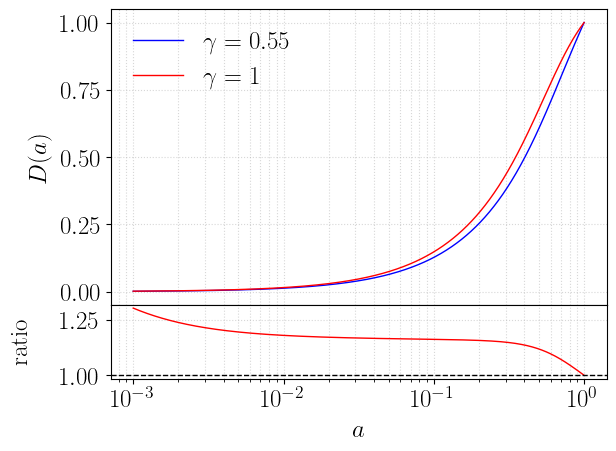

In [39]:
fig, ax = plt.subplots(2, sharex=True, sharey=False, gridspec_kw={'hspace': 0., 'wspace':0., 'height_ratios':[8, 2]}, figsize=(6.4, 4.8))
cutoff=0
ax[0].semilogx(a[cutoff:],D_num[cutoff:],ls='-',c='b',label=r'$\gamma=0.55$')
ax[0].semilogx(a[cutoff:],D_gamma_num[cutoff:],ls='-',c='r',label=r'$\gamma=1$')
ax[0].grid(True, which="both", ls=":",alpha=0.5)
ax[1].set_xlabel(r'$a$')
ax[0].set_ylabel(r'$D(a)$')
ax[1].semilogx(a[cutoff:],D_gamma[cutoff:]/D[cutoff:],color='r')
ax[1].axhline(y=1.0,ls='--',c='k')
ax[1].grid(True,which="both",ls=':',alpha=0.5)
ax[1].set_ylabel(r'ratio',labelpad=20)
ax[0].legend(loc='upper left');
#ax[0].set_title('LCDM vs. $\gamma_0=0.55,\gamma_1=1.0$ growth factor');

### Compare linear $P(k,z=1.5)$ rescaled by different $D^2_\gamma(z=1.5)$ from the numpy integrals

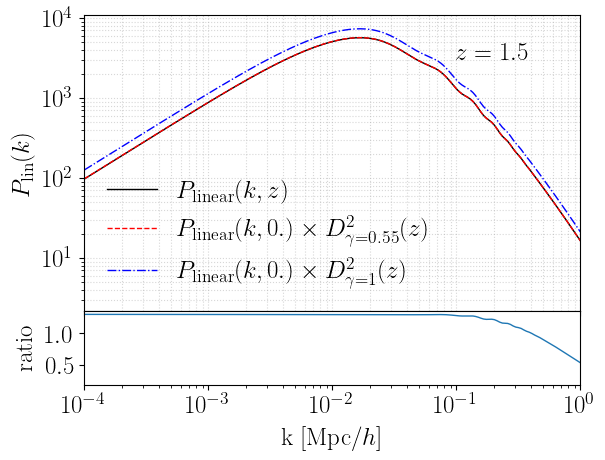

In [50]:
fig, ax = plt.subplots(2, sharex=True, sharey=False, gridspec_kw={'hspace': 0., 'wspace':0., 'height_ratios':[8, 2]}, figsize=(6.4, 4.8))
ax[0].loglog(kh, pk_lin[1,:], color='k', ls = '-', label=r'$P_{\mathrm{linear}}(k,z)$')
ax[0].loglog(kh, pk_check, color='r', ls = '--', label=r'$P_{\mathrm{linear}}(k,0.)\times D_{\gamma=0.55}^2(z)$')
ax[0].loglog(kh, pk_gamma, color='b', ls = '-.', label=r'$P_{\mathrm{linear}}(k,0.)\times D_{\gamma=1}^2(z)$')
ax[0].text(0.75, 0.85,r'$z=1.5$',transform=ax[0].transAxes)
ax[0].set_xlim(1E-4,1)
ax[1].set_xlabel(r'k [Mpc/$h$]')
ax[0].set_ylabel(r'$P_{\mathrm{lin}}(k)$')
ax[0].grid(True, which="both", ls=":",alpha=0.5)
ax[0].legend(loc='lower left')
ax[1].semilogx(kh,pk_gamma/pk_nonlin[1,:])
ax[1].set_ylabel(r'ratio');
#ax[0].set_title(r'LCDM vs. $\gamma_0=0.55,\gamma_1=1.0$ linear power at z=%s'%z[1]);

### Compare the ratio between nonlinear $P_{\gamma}(k,z=1.5)$ and the ratio between corresponding $D^2_{\gamma}(z)$ from the numpy integrals
#### The numpy integral agrees well with the (fortran) integral in CAMB_GammaPrime_Growth, but not numerically exact

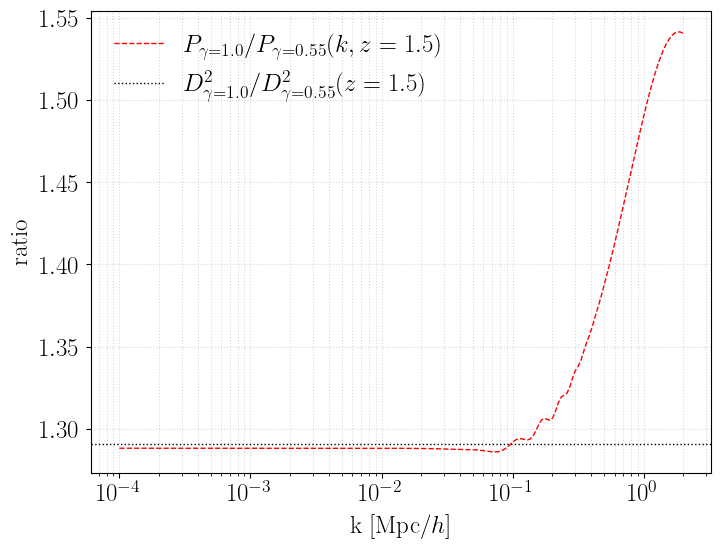

In [52]:
cosmo_params = camb.CAMBparams()
### Consider LCDM cosmology with only one massive neutrino, helium then set through the BBN consistency
cosmo_params.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06,gamma0=1.0,gamma1=0.0)

#### Consider the usual power-law initial power spectrum (of primordial fluctuations)
cosmo_params.InitPower.set_params(As=2e-9, ns=0.965, r=0)

npoints=int(1E5)
a=np.linspace(0.001,1.0,npoints)
redshift_snaphots=[1.5,0.]

kmin=1e-4
kmax=2.0
### Note that here you probably want to extend the k-range to at least 2 kmax being considered later
cosmo_params.set_matter_power(redshifts=redshift_snaphots, kmax=2*kmax);

#cosmo_params.NonLinear = model.NonLinear_none
results = camb.get_results(cosmo_params)
kh, z, pk_lin_gamma = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints = 200)
#np.savetxt('test_pklin_gamma_z1p5.txt',(kh,pk_lin_gamma[1,:]))

### Non-linear power spectra (Halofit)
cosmo_params.NonLinear = model.NonLinear_both
cosmo_params.NonLinearModel.set_params(halofit_version='mead2020')
results = camb.get_results(cosmo_params)
#results.calc_power_spectra(cosmo_params)
kh_nonlin, z_nonlin, pk_nonlin_gamma = results.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints = 200)
#np.savetxt('test_pknonlin_gamma_z1p5.txt',(kh,pk_nonlin_gamma[1,:]))

fig,ax=plt.subplots()
ax.semilogx(kh, pk_nonlin_gamma[1,:]/pk_nonlin[1,:], color='r', ls = line, label=r'$P_{\gamma=1.0}/P_{\gamma=0.55}(k,z=1.5)$')
ax.axhline((D_gamma_num[idx]/D_num[idx])**2,ls=':',color='k',label='$D^2_{\gamma=1.0}/D^2_{\gamma=0.55}(z=1.5)$')
ax.set_xlabel(r'k [Mpc/$h$]')
ax.set_ylabel(r'ratio')
#ax.set_ylim(1-(1E-13),1+(1E-13))
#ax.yaxis.set_major_locator(MultipleLocator(2E-3))
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
#ax.yaxis.set_minor_locator(MultipleLocator(2E-4))
#ax.set_xlim(1E-4,1)
ax.grid(True, which="both", ls=":",alpha=0.5)
ax.legend(loc='upper left');